## 概要

脳の機能解析に使用されるEEG(脳波計)やMEG(脳磁図)の計測結果（つまり、電圧や磁場の時系列データ）には色々なノイズがのります。例えばEEGでは電源ノイズ、筋電、まばたき、などが主要なノイズとして知られています。
電源ノイズのように周波数が分かっていればフィルタでノイズを除去できますが、筋電やまばたきのような周波数が分からないものでは難しいです。
そこで、計測信号を欲しい信号（例えば脳波信号）とノイズに分離するために、2000年前後から独立成分分析Independent Component Analysis(ICA)という方法が使われており、これが脳波計測に限らずけっこう便利なので、紹介します（音声認識分野での応用が盛んなようです）。

詳細な原理や数式は[1]にあるのでそちらを見てほしいのですが、基本コンセプトは、「ある点で観測される信号が複数の信号源から発せられる各信号の線形結合で表されると仮定したとき、観測した各信号を無相関にするような線形変換が存在する」ということです。わかりやすくいえば、「ある仮定を置き、ある条件を満たせたとき、混ざりあった信号を元の信号に分離できる」ということです。

脳波計や脳磁図では脳表面の複数の点で計測を行うので、この複数の信号を使って、互いに独立な信号に分けることができます。この分けた信号一つ一つが、電源ノイズだったり、筋電だったり、所望の脳波だったりすることが期待されるわけです。

以下、例を実装してみます。

## 実装
Scikit-LearnのFastICAという関数を使います。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

信号源を3つ設定します。例として代表的な脳波であるα波(10Hz)、電源ノイズ(60Hz)、平均0・分散1のガウスノイズ、を設定します。

In [2]:
t = np.arange(0, 1, 0.001)

s1 = np.sin(2.0 * np.pi * 10 * t)
s2 = np.sin(2.0 * np.pi * 60 * t)
s3 = np.random.normal(loc=0, scale=1, size=len(t))

信号源sをプロットします。左からα波、電源ノイズ、ガウスノイズです。

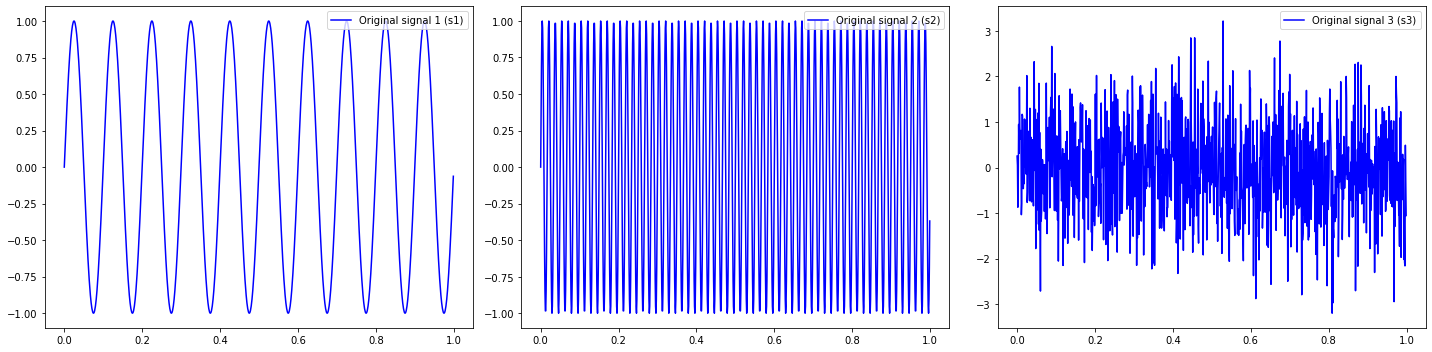

In [3]:
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
ax1.plot(t, s1, color="blue", label="Original signal 1 (s1)")
ax2.plot(t, s2, color="blue", label="Original signal 2 (s2)")
ax3.plot(t, s3, color="blue", label="Original signal 3 (s3)")
ax1.legend(loc = 'upper right') 
ax2.legend(loc = 'upper right') 
ax3.legend(loc = 'upper right') 
fig.tight_layout()
plt.show()

信号源sを適当に混ぜて（適当に線形結合して）計測信号yを生成します。

In [4]:
y1 = 0.3 * s1 + 0.4 * s2 + 0.3 * s3
y2 = 0.4 * s1 + 0.1 * s2 + 0.5 * s3
y3 = 0.1 * s1 + 0.1 * s2 + 0.8 * s3

計測信号yをプロットします。これが実際に計測される信号ですが、元がどんな信号かだいぶわかりづらいかと思います。

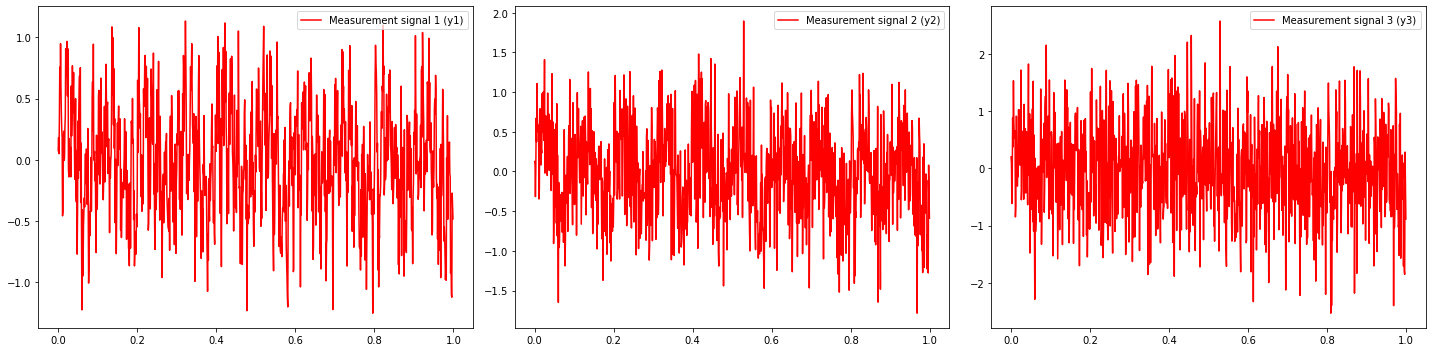

In [5]:
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
ax1.plot(t, y1, color="red",  label="Measurement signal 1 (y1)")
ax2.plot(t, y2, color="red", label="Measurement signal 2 (y2)")
ax3.plot(t, y3, color="red", label="Measurement signal 3 (y3)")
ax1.legend(loc = 'upper right') 
ax2.legend(loc = 'upper right') 
ax3.legend(loc = 'upper right') 
fig.tight_layout()
plt.show()

計測信号を独立成分分析（ICA）にかけます。

In [6]:
Y = np.vstack([y1, y2, y3]).T

ica = FastICA(n_components=3, whiten=True)
ica.fit(Y)

FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
        n_components=3, random_state=None, tol=0.0001, w_init=None,
        whiten=True)

ICAの結果から元の信号を推定(復元)します。復元信号はxとします。

In [7]:
X = ica.transform(Y)
x1 = np.array(X.T[0,:])
x2 = np.array(X.T[1,:])
x3 = np.array(X.T[2,:])

復元信号xをプロットします。混ざった信号から復元を行っているため、元の信号とは順番が異なる（つまり、復元信号の意味づけは人間が行わなければならない）、振幅が異なることに注意が必要ですが、だいぶ復元できていることがわかります。

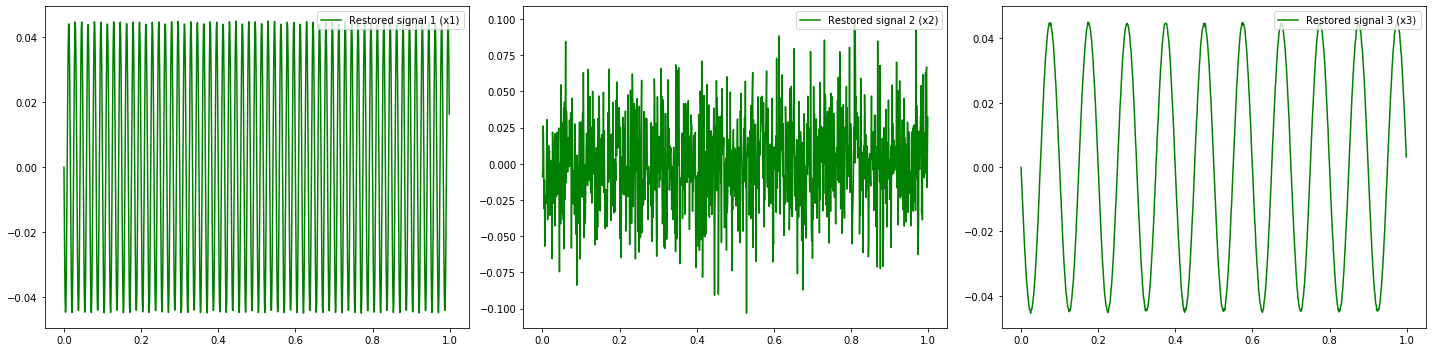

In [8]:
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
ax1.plot(t, x1, color="green", label="Restored signal 1 (x1)")
ax2.plot(t, x2, color="green", label="Restored signal 2 (x2)")
ax3.plot(t, x3, color="green", label="Restored signal 3 (x3)")
ax1.legend(loc = 'upper right') 
ax2.legend(loc = 'upper right') 
ax3.legend(loc = 'upper right') 
fig.tight_layout()
plt.show()

## 参考
[1]「独立成分解析の信号処理への応用」, 池田, さきがけ研究21「情報と知」領域  
- 原理と数式が書いてあります。
  
[2] scikit-learnでPCAとFastICA, <https://takmin.hatenablog.com/entry/20120621/1340254109>
- 実装時に参考にしました。

[3] sklearn.decomposition.FastICA, <https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html>
- Scikit-Learn/FastICAの説明です。